In [1]:
from __future__ import print_function, division

from keras.layers import Input, Dense, GaussianNoise, LeakyReLU, Dropout,BatchNormalization, Activation
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import to_categorical

import numpy as np
import scipy.io as sio
import argparse
import matplotlib.pyplot as plt

In [2]:
# I didn't use this function
def get_max_idx_loglikelihood(y,x):
    # maxL for AWGN channel
    N = np.size(x,0)
    distances = np.zeros((N,1))
    for i in range(N):
        pass
    return np.argmin(distances)

In [3]:
def from_zero_mean_bits_to_digit(x,M=2):
    #convert to binary representation
    # M = 2 
    x = (x + (M-1)) / 2 # representation with 0 and 1
    print(x)
    N = np.size(x,0)
    d = np.size(x,1)
    digits = np.zeros((N,1))
    for i in range(d):
        digits[i] = np.sum([(2**(N-1-j))*x[i][j] for j in range(N)])
    return digits

In [4]:
def from_digit_to_zero_mean_bits(x,k):
    # convert from digit to zero mean
    M = len(x) # number of rows
    output = np.zeros((M,k))
    for count,value in enumerate(x):
        output[count,:] = np.array([int(digit) for digit in format(value[0],f"#0{k+2}b")[2:]])    
    output = 2*output-1
    return output


In [5]:
x = np.array(np.random.randint(0,16,(10,1)))
from_digit_to_zero_mean_bits(x,4)

array([[-1., -1., -1.,  1.],
       [-1., -1., -1., -1.],
       [-1., -1., -1.,  1.],
       [-1., -1.,  1., -1.],
       [-1.,  1., -1., -1.],
       [-1., -1.,  1.,  1.],
       [-1.,  1., -1., -1.],
       [ 1., -1., -1., -1.],
       [-1., -1.,  1.,  1.],
       [-1., -1.,  1., -1.]])

In [6]:
G_7_4 = np.array([[1,0,0,0,1,0,1],
              [0,1,0,0,1,1,1],
              [0,0,1,0,1,1,0],
              [0,0,0,1,0,1,1]])

In [7]:
def from_digit_to_7_bits(x):
    x = from_digit_to_zero_mean_bits(x,4)
    x = (x+1)/2
    x = x.dot(G_7_4)
    x = x % 2
    x = 2*x-1
    return(x)

In [8]:
class NeuralDecoder():
    def __init__(self, EbN0):

        # Input shape
        self.input_dim = 7
        self.EbN0 = EbN0

        # Noise std based on EbN0 in dB
        eps = np.sqrt(pow(10, -0.1 * self.EbN0) / (2 * 0.5))
        self.eps = eps
        
        # 0.01 is the learning rate
        #    -> how much we want to moove after each epoch
        # 0.5 is the exponential decay rate for the 1st moment estimates 
        #    -> avoid to be stuck when we are close to the optimum by updating the learning rate
        # we change this value to converge faster to the optimum
        # Adam use momentum and velocity to deal with this problème
        
        optimizer = Adam(0.01, 0.5)

        # Build and compile the classifier. Model parameters are randomly initialized
        self.classifier = self.build_classifier()
        
        ###########################################
        # we define the input and then the output
        ###########################################
        
        # Definition of the input tensor
        y = Input(shape=(self.input_dim,))

        # Classifier output, a vector of probabilities
        p_s = self.classifier(y)
        
        ##############################################
        # we have to do the initialisation of the model
        ##############################################
        
        # Definition of the classifier model and training loss
        self.combined = Model(y, p_s)

        # The categorical cross-entropy is used as loss function
        # we will use crossentropy because it is classification and Adam for optimizing the weigth
        self.combined.compile(loss='categorical_crossentropy', optimizer=optimizer)

    def build_classifier(self):

        model = Sequential()
        # ADD your NN model here
        
        ##############################################
        # We have to choose the number of neurons 
        # and the activation function for each layer
        ##############################################
        
        # Input layer has 7 neuron (single received sample) and the hidden layer 100 neurons with ReLU as activation
        
        
        model.add(Dense(128,input_dim=self.input_dim))
        model.add(Activation('relu'))
        model.add(Dropout(0.3))
        
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dropout(0.3))
        
        
        # Last layer has 16 neurons (16 classes) with softmax as activation (given the cross-entropy as loss)
        # allow us to have a vector of probabilities
        model.add(Dense(16, activation='softmax'))
        
        # allow us to display the model
        model.summary()
        
        T = Input(shape=(self.input_dim,))
        C = model(T)

        return Model(T, C)

    def train(self, epochs, batch_size=40):

        M = 16 # alphabet dimension

        # ADD define the generator matrix G_7_4
        G_7_4 = np.array([[1,0,0,0,1,0,1],
                          [0,1,0,0,1,1,1],
                          [0,0,1,0,1,1,0],
                          [0,0,0,1,0,1,1]])
        
        full_loss = np.zeros((epochs,1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Decoder
            # ---------------------

            # Generate data to transmit
            # Write some lines to generate data_tx
            
            y_tx = np.random.randint(0,16,(batch_size,1))
            data_tx = from_digit_to_zero_mean_bits(y_tx,4)
            data_tx = (data_tx +1)/2
            data_tx = data_tx.dot(G_7_4)
            data_tx = data_tx % 2
            data_tx = 2*data_tx -1
            eps = self.eps
            
            # Simulate the AWGN noise and produce the received samples
            data_rx = data_tx + eps*np.random.normal(0, 1, (batch_size, self.input_dim))
            # Transform the labels into categorical values for the cross-entropy
            
            ### What happends if we don't have all the M classes in y_tx ????
            
            y_cat = to_categorical(y_tx, num_classes=M)

            # Single step training iteration using a batch of data to compute the gradient and update the model parameters
            d_loss = self.combined.train_on_batch(data_rx, y_cat)
            
            # Save the loss value for visualization purposes
            full_loss[epoch] = d_loss
        
        plt.plot(full_loss)
        plt.xlabel('Epoch')
        plt.title('Cross-entropy training loss')
        plt.show()
        return full_loss[-1]


    def test(self, test_size=1000):
        eps = self.eps
        BER = np.zeros((1, test_size))
        BER_maxL = np.zeros((1, test_size))

        # Define the entire transmitted data
        
        y_tx = np.random.randint(0,16,(test_size,1))
        data_tx = from_digit_to_zero_mean_bits(y_tx,4)
        data_tx = (data_tx +1)/2
        data_tx = data_tx.dot(G_7_4)
        data_tx = data_tx % 2
        data_tx = 2*data_tx -1

        for i in range(test_size):

            # Generate the output
            data_rx = data_tx[i, :] + eps * np.random.normal(0, 1, (1, self.input_dim)) # AWGN model
            
            R = self.classifier.predict(data_rx,verbose=0) # predictions/output of the NN
            prediction = np.argmax(R)
            prediction = from_digit_to_7_bits(np.array([[prediction]]))
            
            # Write the code to obtain the bit-error-rate for the neural decoder and the classical maximum-likelihood
            pred = prediction[0]
            # compare with 7 encoding bit
            BER[0, i] = sum(pred!=data_tx[i,:])
            #sum([int(digit) for digit in format(np.argmax(R)^y_tx[i][0],f"#0{6}b")[2:]])
            
            # back to 0 - 1 bit
            a = (pred+1)/2
            b = (data_tx[i,:]+1)/2
            # euclidian distance 
            BER_maxL[0, i] = np.sqrt(sum((a-b)**2))

        # Return the average BERs
        
        # we have to compute the mean
        
        return np.mean(BER),np.mean(BER_maxL)

Actual SNR is:-20
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16

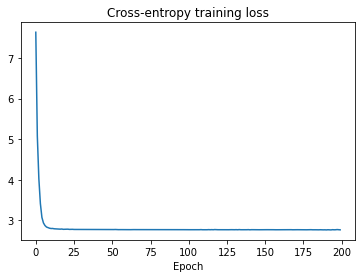

Actual SNR is:-19
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1024      
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 activation_3 (Activation)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 

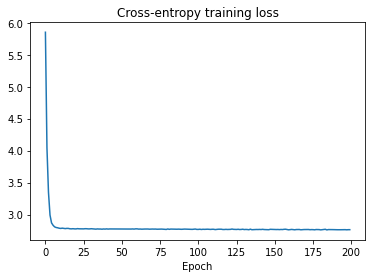

Actual SNR is:-18
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1024      
                                                                 
 activation_4 (Activation)   (None, 128)               0         
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 

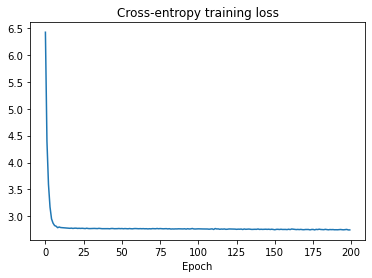

Actual SNR is:-17
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               1024      
                                                                 
 activation_6 (Activation)   (None, 128)               0         
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 activation_7 (Activation)   (None, 64)                0         
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 

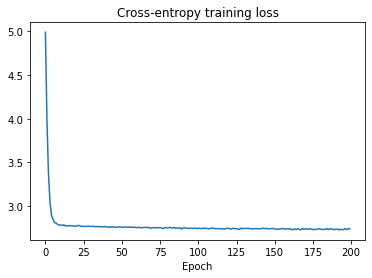

Actual SNR is:-16
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               1024      
                                                                 
 activation_8 (Activation)   (None, 128)               0         
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 activation_9 (Activation)   (None, 64)                0         
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 

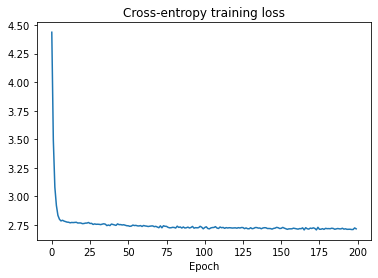

Actual SNR is:-15
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               1024      
                                                                 
 activation_10 (Activation)  (None, 128)               0         
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 activation_11 (Activation)  (None, 64)                0         
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 

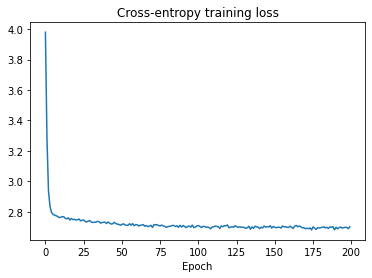

Actual SNR is:-14
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               1024      
                                                                 
 activation_12 (Activation)  (None, 128)               0         
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 activation_13 (Activation)  (None, 64)                0         
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 

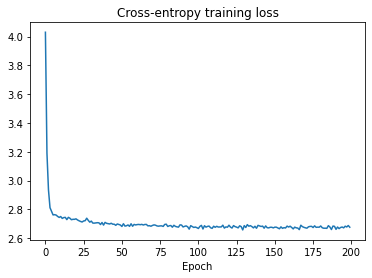

Actual SNR is:-13
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               1024      
                                                                 
 activation_14 (Activation)  (None, 128)               0         
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 activation_15 (Activation)  (None, 64)                0         
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 

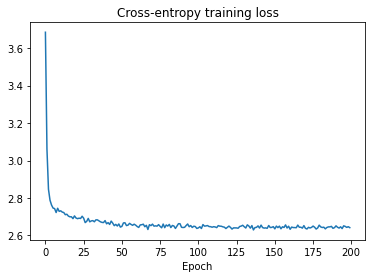

Actual SNR is:-12
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               1024      
                                                                 
 activation_16 (Activation)  (None, 128)               0         
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 activation_17 (Activation)  (None, 64)                0         
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 

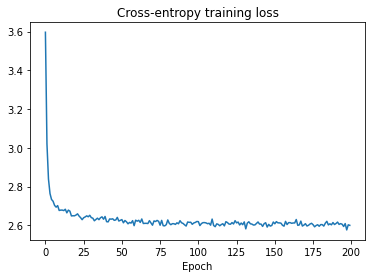

Actual SNR is:-11
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 128)               1024      
                                                                 
 activation_18 (Activation)  (None, 128)               0         
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 activation_19 (Activation)  (None, 64)                0         
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 

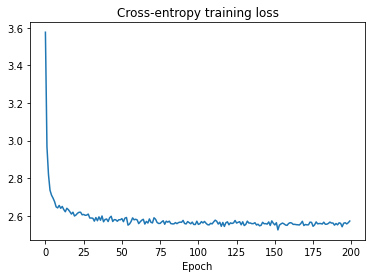

Actual SNR is:-10
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               1024      
                                                                 
 activation_20 (Activation)  (None, 128)               0         
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 activation_21 (Activation)  (None, 64)                0         
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None,

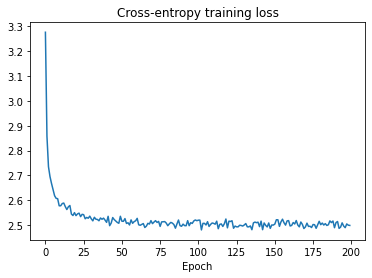

Actual SNR is:-9
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               1024      
                                                                 
 activation_22 (Activation)  (None, 128)               0         
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 activation_23 (Activation)  (None, 64)                0         
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 

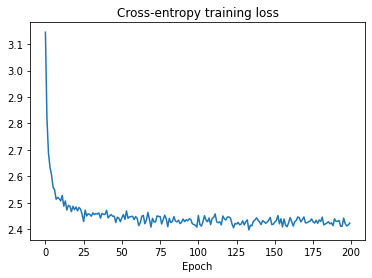

Actual SNR is:-8
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               1024      
                                                                 
 activation_24 (Activation)  (None, 128)               0         
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 activation_25 (Activation)  (None, 64)                0         
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 

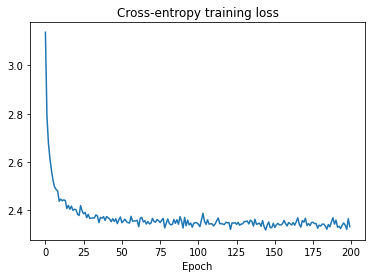

Actual SNR is:-7
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 128)               1024      
                                                                 
 activation_26 (Activation)  (None, 128)               0         
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 activation_27 (Activation)  (None, 64)                0         
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 

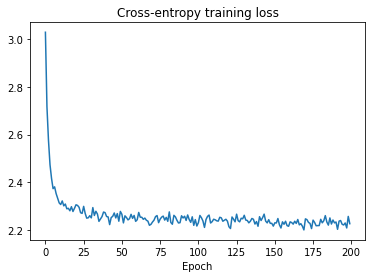

Actual SNR is:-6
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               1024      
                                                                 
 activation_28 (Activation)  (None, 128)               0         
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 activation_29 (Activation)  (None, 64)                0         
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 

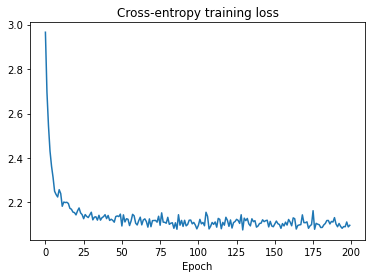

Actual SNR is:-5
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 128)               1024      
                                                                 
 activation_30 (Activation)  (None, 128)               0         
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 64)                8256      
                                                                 
 activation_31 (Activation)  (None, 64)                0         
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 

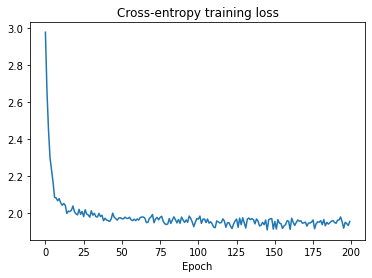

Actual SNR is:-4
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 128)               1024      
                                                                 
 activation_32 (Activation)  (None, 128)               0         
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_49 (Dense)            (None, 64)                8256      
                                                                 
 activation_33 (Activation)  (None, 64)                0         
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 

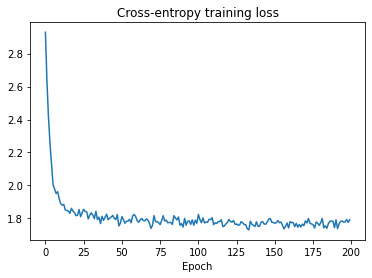

Actual SNR is:-3
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 128)               1024      
                                                                 
 activation_34 (Activation)  (None, 128)               0         
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 activation_35 (Activation)  (None, 64)                0         
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 

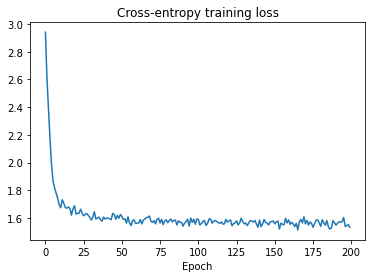

Actual SNR is:-2
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 128)               1024      
                                                                 
 activation_36 (Activation)  (None, 128)               0         
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 activation_37 (Activation)  (None, 64)                0         
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_56 (Dense)            (None, 

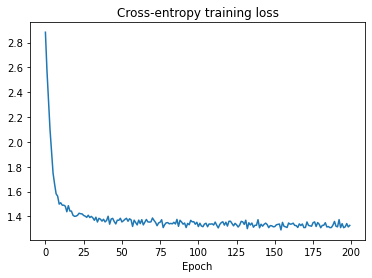

Actual SNR is:-1
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 128)               1024      
                                                                 
 activation_38 (Activation)  (None, 128)               0         
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_58 (Dense)            (None, 64)                8256      
                                                                 
 activation_39 (Activation)  (None, 64)                0         
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 

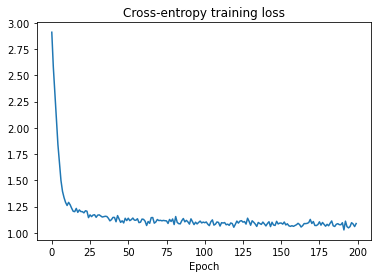

Actual SNR is:0
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 128)               1024      
                                                                 
 activation_40 (Activation)  (None, 128)               0         
                                                                 
 dropout_40 (Dropout)        (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 activation_41 (Activation)  (None, 64)                0         
                                                                 
 dropout_41 (Dropout)        (None, 64)                0         
                                                                 
 dense_62 (Dense)            (None, 1

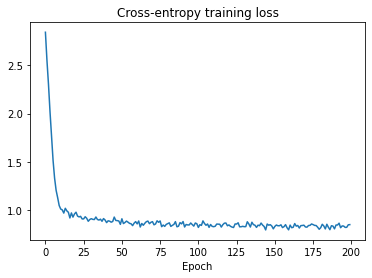

Actual SNR is:1
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 128)               1024      
                                                                 
 activation_42 (Activation)  (None, 128)               0         
                                                                 
 dropout_42 (Dropout)        (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 activation_43 (Activation)  (None, 64)                0         
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         
                                                                 
 dense_65 (Dense)            (None, 1

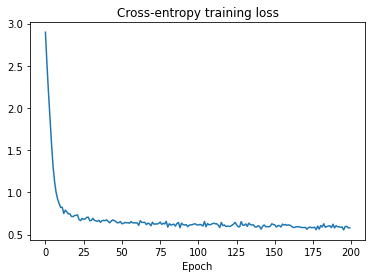

Actual SNR is:2
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 128)               1024      
                                                                 
 activation_44 (Activation)  (None, 128)               0         
                                                                 
 dropout_44 (Dropout)        (None, 128)               0         
                                                                 
 dense_67 (Dense)            (None, 64)                8256      
                                                                 
 activation_45 (Activation)  (None, 64)                0         
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_68 (Dense)            (None, 1

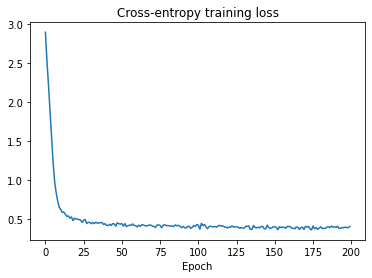

Actual SNR is:3
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 128)               1024      
                                                                 
 activation_46 (Activation)  (None, 128)               0         
                                                                 
 dropout_46 (Dropout)        (None, 128)               0         
                                                                 
 dense_70 (Dense)            (None, 64)                8256      
                                                                 
 activation_47 (Activation)  (None, 64)                0         
                                                                 
 dropout_47 (Dropout)        (None, 64)                0         
                                                                 
 dense_71 (Dense)            (None, 1

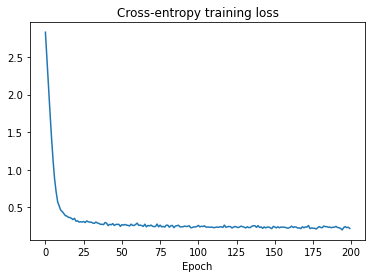

Actual SNR is:4
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 128)               1024      
                                                                 
 activation_48 (Activation)  (None, 128)               0         
                                                                 
 dropout_48 (Dropout)        (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 64)                8256      
                                                                 
 activation_49 (Activation)  (None, 64)                0         
                                                                 
 dropout_49 (Dropout)        (None, 64)                0         
                                                                 
 dense_74 (Dense)            (None, 1

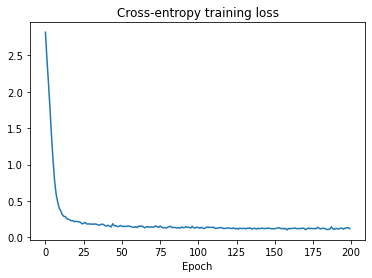

Actual SNR is:5
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 128)               1024      
                                                                 
 activation_50 (Activation)  (None, 128)               0         
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_76 (Dense)            (None, 64)                8256      
                                                                 
 activation_51 (Activation)  (None, 64)                0         
                                                                 
 dropout_51 (Dropout)        (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 1

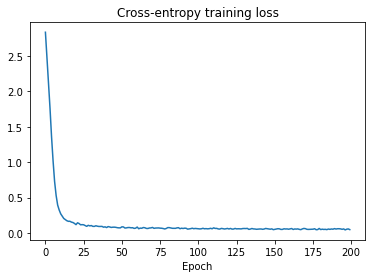

Actual SNR is:6
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 128)               1024      
                                                                 
 activation_52 (Activation)  (None, 128)               0         
                                                                 
 dropout_52 (Dropout)        (None, 128)               0         
                                                                 
 dense_79 (Dense)            (None, 64)                8256      
                                                                 
 activation_53 (Activation)  (None, 64)                0         
                                                                 
 dropout_53 (Dropout)        (None, 64)                0         
                                                                 
 dense_80 (Dense)            (None, 1

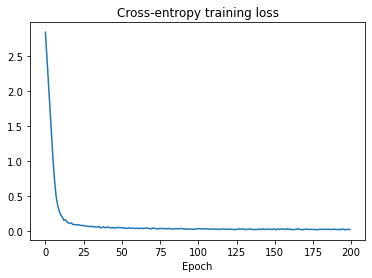

Actual SNR is:7
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 128)               1024      
                                                                 
 activation_54 (Activation)  (None, 128)               0         
                                                                 
 dropout_54 (Dropout)        (None, 128)               0         
                                                                 
 dense_82 (Dense)            (None, 64)                8256      
                                                                 
 activation_55 (Activation)  (None, 64)                0         
                                                                 
 dropout_55 (Dropout)        (None, 64)                0         
                                                                 
 dense_83 (Dense)            (None, 1

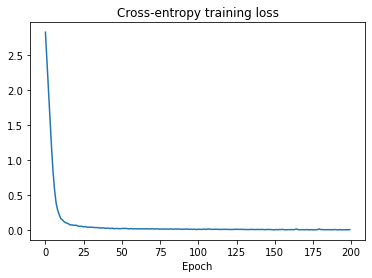

Actual SNR is:8
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 128)               1024      
                                                                 
 activation_56 (Activation)  (None, 128)               0         
                                                                 
 dropout_56 (Dropout)        (None, 128)               0         
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 activation_57 (Activation)  (None, 64)                0         
                                                                 
 dropout_57 (Dropout)        (None, 64)                0         
                                                                 
 dense_86 (Dense)            (None, 1

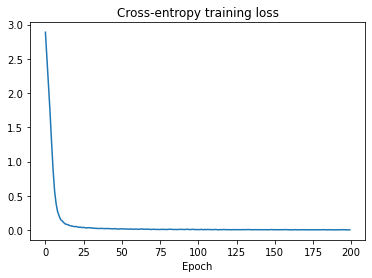

Actual SNR is:9
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 128)               1024      
                                                                 
 activation_58 (Activation)  (None, 128)               0         
                                                                 
 dropout_58 (Dropout)        (None, 128)               0         
                                                                 
 dense_88 (Dense)            (None, 64)                8256      
                                                                 
 activation_59 (Activation)  (None, 64)                0         
                                                                 
 dropout_59 (Dropout)        (None, 64)                0         
                                                                 
 dense_89 (Dense)            (None, 1

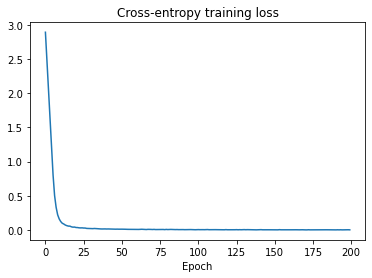

Actual SNR is:10
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 128)               1024      
                                                                 
 activation_60 (Activation)  (None, 128)               0         
                                                                 
 dropout_60 (Dropout)        (None, 128)               0         
                                                                 
 dense_91 (Dense)            (None, 64)                8256      
                                                                 
 activation_61 (Activation)  (None, 64)                0         
                                                                 
 dropout_61 (Dropout)        (None, 64)                0         
                                                                 
 dense_92 (Dense)            (None, 

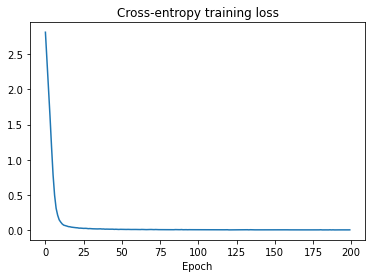

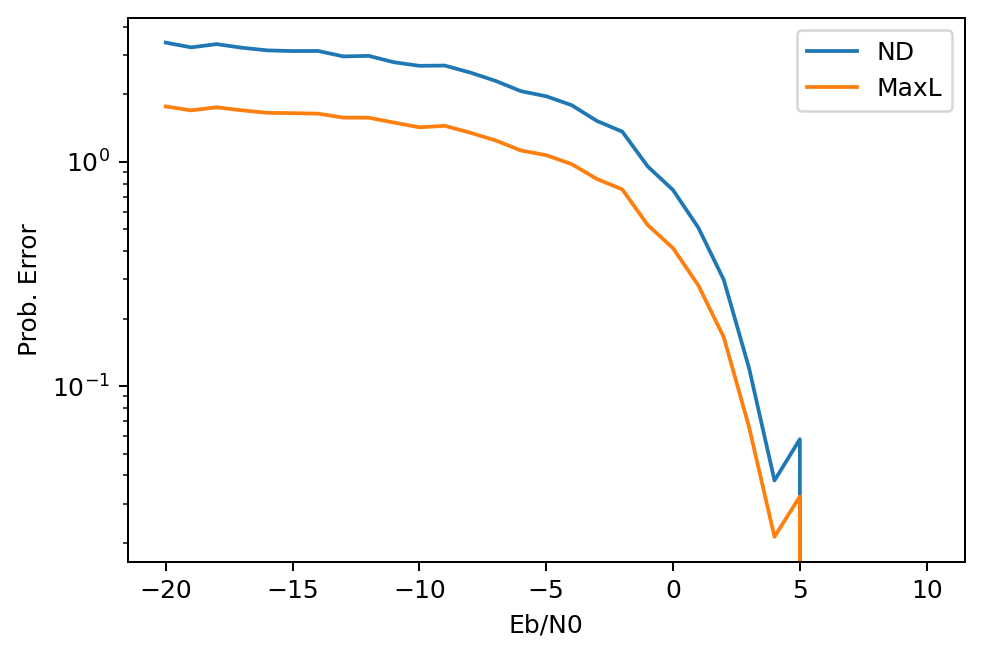

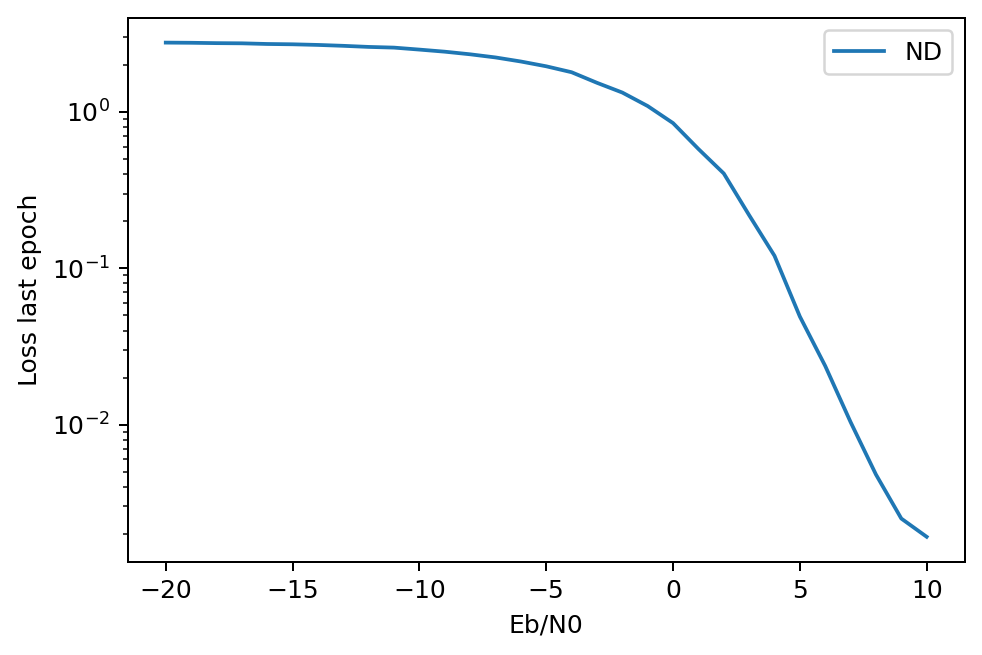

In [9]:
batch_size = 5000
epochs = 200
test_size = 500
lossLastEpoch = []

test_size = int(test_size)

#SNR_dB = range(-20,11,4)
SNR_dB = range(-20,11)
ber_total = np.zeros((len(SNR_dB),1))
ber_total_LL = np.zeros((len(SNR_dB),1))


j = 0
# Do train and test for every SNR
for SNR in SNR_dB:
    print(f'Actual SNR is:{SNR}')
    # Initialize the decoder
    ND = NeuralDecoder(SNR)
    # Train the decoder for the specific SNR
    lossLastEpoch.append(ND.train(epochs=int(epochs), batch_size=int(batch_size)))
    # Test and get the bit-error-rate
    ber, ber_maxL = ND.test(test_size=test_size)
    ber_total[j,0] = ber
    ber_total_LL[j,0] = ber_maxL

    del ND
    j = j+1

# Plot in logarithmic scale the BERs
plt.figure(figsize=(6, 4), dpi=180)
plt.semilogy(SNR_dB, ber_total, label='ND')
plt.semilogy(SNR_dB, ber_total_LL, label='MaxL')

plt.xlabel("Eb/N0")
plt.ylabel("Prob. Error")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4), dpi=180)
plt.semilogy(SNR_dB, lossLastEpoch, label='ND')

plt.xlabel("Eb/N0")
plt.ylabel("Loss last epoch")
plt.legend()
plt.show()
